## experiment state manager


In [1]:
from typing import Literal, Callable, Self

import numpy as np
from numpy.typing import NDArray
from numpy.random import RandomState, MT19937, SeedSequence


class POPOPState:
    POPULATION_VARY_METHODS = ("uniform_crossover",)
    INDIVIDUALS_SELECTION_METHODS = ("tournament", "truncation", "proportional")

    def __init__(
        self,
        individual_size: int,
        population_size: int,
        population_vary_method: Literal["uniform_crossover"],
        population_vary_probability_threshold: float,
        individual_selection_method: Literal[
            "tournament", "truncation", "proportional"
        ],
        fitness_fn: Callable[[NDArray[np.uint8]], int],
        max_evaluations: int,
        tournament_size: int = 2,
        truncation_size: int | None = None,
        proportional_size: int | None = None,
        random_seed: int | None = None,
    ):
        if population_vary_method not in self.POPULATION_VARY_METHODS:
            raise ValueError(
                f"`population_vary_method`={population_vary_method} does not exists or is yet to be implemented."
            )

        if individual_selection_method not in self.INDIVIDUALS_SELECTION_METHODS:
            raise ValueError(
                f"`individual_selection_method`={individual_selection_method} does not exists or is yet to be implemented."
            )

        if individual_selection_method == "truncation" and truncation_size is None:
            truncation_size = population_size

        if individual_selection_method == "proportional" and proportional_size is None:
            proportional_size = population_size

        self._random_state = RandomState(MT19937(SeedSequence(random_seed)))
        self._individual_size = individual_size
        self._population_size = population_size
        self._population_vary_method = population_vary_method
        self._population_vary_probability_threshold = (
            population_vary_probability_threshold
        )
        self._individual_selection_method = individual_selection_method
        self._tournament_size = tournament_size
        self._truncation_size = truncation_size
        self._proportional_size = proportional_size
        self._fitness_fn = fitness_fn
        self._max_evaluations = max_evaluations
        self._current_evaluations = 0
        self._population: NDArray[np.uint8] | None = None
        self._offsprings: NDArray[np.uint8] | None = None
        self._best_fitnesses: list[int] = []
        self._best_fitness_evaluations: list[int] = []

    def fitness_fn(self, individual: NDArray[np.uint8]):
        self._current_evaluations += 1
        return self._fitness_fn(individual)

    def initialize_population(self) -> Self:
        self._population = self._random_state.randint(
            low=0,
            high=2,
            size=(self._population_size, self._individual_size),
            dtype=np.uint8,
        )
        return self

    def generate_offsprings(self) -> Self:
        if self._population is None:
            raise ValueError(
                "population has to be initialize with method `initialize_population` in order to generate offsprings."
            )

        if self._population_vary_method == "uniform_crossover":
            shuffled_popluation_indices = np.arange(self._population_size).tolist()
            self._random_state.shuffle(shuffled_popluation_indices)

            offsprings: list[list[int]] = []

            random_state_rand = self._random_state.rand
            for i in range(0, self._population_size, 2):
                offspring0_index = shuffled_popluation_indices[i]
                offspring1_index = shuffled_popluation_indices[i + 1]
                offspring0 = self._population[offspring0_index].tolist()
                offspring1 = self._population[offspring1_index].tolist()

                for parameter_index in range(0, self._individual_size):
                    crossover_probabiliy = random_state_rand()
                    if (
                        crossover_probabiliy
                        < self._population_vary_probability_threshold
                    ):
                        offspring0[parameter_index], offspring1[parameter_index] = (
                            offspring1[parameter_index],
                            offspring0[parameter_index],
                        )

                offsprings.extend((offspring0, offspring1))

            self._offsprings = np.array(offsprings, dtype=np.uint8)

        return self

    def _update_best_fitnesses(self, best_fitness: int):
        self._best_fitnesses.append(best_fitness)
        self._best_fitness_evaluations.append(self._current_evaluations)

    def _tournament_select(self, individuals_pool: NDArray[np.uint8]):
        fitness_fn = self.fitness_fn
        individual_fitnesses = np.array(
            [fitness_fn(x) for x in individuals_pool], dtype=np.uint
        )
        best_fitness = np.max(individual_fitnesses)
        self._update_best_fitnesses(int(best_fitness))

        selections: list[NDArray[np.uint8]] = []
        shuffled_individuals_pool_indices = np.arange(0, individuals_pool.shape[0])

        random_state_shuffle = self._random_state.shuffle
        selections_append = selections.append
        while len(selections) < self._population_size:
            random_state_shuffle(shuffled_individuals_pool_indices)

            for i in range(0, individuals_pool.shape[0], self._tournament_size):
                argmax_tournament_i = np.argmax(
                    individual_fitnesses[
                        shuffled_individuals_pool_indices[i : i + self._tournament_size]
                    ]
                )

                selections_append(
                    individuals_pool[
                        shuffled_individuals_pool_indices[i + argmax_tournament_i]
                    ]
                )

        selections = selections[: self._population_size]
        return np.vstack(selections, dtype=np.uint8)

    def _truncation_select(self, individuals_pool: NDArray[np.uint8]):
        individual_fitnesses = [self.fitness_fn(x) for x in individuals_pool]

        assert self._truncation_size is not None
        selected_indices = np.argsort(individual_fitnesses)[-self._truncation_size :]

        best_fitness = max(individual_fitnesses)
        self._update_best_fitnesses(best_fitness)

        return individuals_pool[selected_indices]

    def _proportional_select(self, individuals_pool: NDArray[np.uint8]):
        individual_fitnesses = [self.fitness_fn(x) for x in individuals_pool]
        total_fitness = sum(individual_fitnesses)
        individual_selection_probabilities = (
            np.array(individual_fitnesses) / total_fitness
        )

        individual_cumulative_selection_probabilities = np.cumsum(
            individual_selection_probabilities
        )
        assert self._proportional_size is not None
        selected_indices = [0 for _ in range(self._proportional_size)]

        rand = self._random_state.rand
        searchsorted = np.searchsorted
        for i in range(self._proportional_size):
            selection_probabilty = rand()
            individual_index = searchsorted(
                individual_cumulative_selection_probabilities,
                selection_probabilty,
                side="right",
            )
            selected_indices[i] = int(individual_index)

        best_fitness = max(individual_fitnesses)
        self._update_best_fitnesses(best_fitness)

        return individuals_pool[selected_indices]

    def select_elite_individuals(self) -> Self:
        assert self._population is not None
        if self._offsprings is None:
            raise ValueError(
                "offsrpings must be generated beforehand with method `generate_offsprings` in order to meaningfully construct elitism in selection, otherwise redundant."
            )

        individuals_pool = np.vstack((self._population, self._offsprings))

        if self._individual_selection_method == "tournament":
            elites = self._tournament_select(individuals_pool)
            self._population = elites
            return self

        if self._individual_selection_method == "truncation":
            elites = self._truncation_select(individuals_pool)
            self._population = elites
            return self

        if self._individual_selection_method == "proportional":
            elites = self._proportional_select(individuals_pool)
            self._population = elites
            return self

        raise NotImplementedError(
            f"selection methods have been declared in `{self.__class__.__name__}` but have yet to be implemented, this is a library development error, not an user usage one."
        )

    @property
    def best_fitnesses(self):
        if len(self._best_fitnesses) == 0:
            raise ValueError(
                "no evaluation has yet to be run, therefore no `best_fitnesses` exists."
            )
        return np.array(self._best_fitnesses, dtype=np.uint)

    @property
    def best_fitness_evaluations(self):
        if len(self._best_fitness_evaluations) == 0:
            raise ValueError(
                "no evaluation has yet to be run, therefore no `best_fitness_evaluations` exists."
            )
        return np.array(self._best_fitness_evaluations, dtype=np.uint)

    @property
    def reached_max_evaluations(self):
        return self._current_evaluations >= self._max_evaluations

    @property
    def individual_size(self):
        return self._individual_size

    @property
    def population_size(self):
        return self._population_size

    @property
    def max_evaluations(self):
        return self._max_evaluations

## fitness functions


In [ ]:
import numpy as np
from numpy.typing import NDArray


def onemax(individual: NDArray[np.uint8]):
    return np.sum(individual, dtype=np.uint).tolist()


def leading_one(individual: NDArray[np.uint8]):
    count = 0
    for bit in reversed(individual):
        bit = int(bit)
        if bit != 1:
            break
        count += 1
    return count


def concatenated_trap_5(individual: NDArray[np.uint8]):
    if individual.shape[0] % 5 != 0:
        raise ValueError(
            f"individual size is {int(individual.shape[0])} indivisible by 5, which is required to perform `concatenated_trap_5` benchmark"
        )

    fitness = 0

    for i in range(0, individual.shape[0], 5):
        enabled_parameters_count = 0

        for section_i in range(0, 5):
            if int(individual[i + section_i]) == 1:
                enabled_parameters_count += 1

        if enabled_parameters_count == 5:
            enabled_parameters_count = 5
            fitness += enabled_parameters_count
            continue

        enabled_parameters_count = 4 - enabled_parameters_count
        fitness += enabled_parameters_count

    return fitness

In [3]:
import numpy as np
from typing import Callable, Literal
from numpy.typing import NDArray


def pipelines(
    fitness_fn: Callable[[NDArray[np.uint8]], int],
    individual_size: int,
    population_size: int,
    individual_selection_method: Literal["tournament", "truncation", "proportional"],
    max_evaluations: int,
):
    for random_seed in range(22520278, 22520278 + 10):
        state = POPOPState(
            individual_size=individual_size,
            population_size=population_size,
            population_vary_method="uniform_crossover",
            population_vary_probability_threshold=0.5,
            individual_selection_method=individual_selection_method,
            tournament_size=4,
            fitness_fn=fitness_fn,
            max_evaluations=max_evaluations,
            random_seed=random_seed,
        ).initialize_population()

        while not state.reached_max_evaluations:
            state = state.generate_offsprings().select_elite_individuals()

        yield state

## plotting function


In [4]:
import numpy as np
from typing import Iterable, Literal
from matplotlib import pyplot as plt


def plot_from_states(
    states: Iterable[POPOPState],
    selection_method: Literal["tournament", "truncation", "proportional"],
    title: str,
    color: str,
):
    fits: list[NDArray[np.uint]] = []
    evaluations: NDArray[np.uint] | None = None
    max_evaluations: int | None = None
    population_size: int | None = None
    individual_size: int | None = None

    for state in states:
        if evaluations is None:
            evaluations = state.best_fitness_evaluations

        if max_evaluations is None:
            max_evaluations = state.max_evaluations

        if population_size is None:
            population_size = state.population_size

        if individual_size is None:
            individual_size = state.individual_size

        best_fitnesses = state.best_fitnesses
        fits.append(best_fitnesses)

    fits_array = np.vstack(fits)

    average: NDArray[np.float64] = np.mean(fits_array, axis=0, dtype=np.float64)
    error: NDArray[np.float64] = np.std(fits_array, axis=0, dtype=np.float64)

    assert evaluations is not None
    assert max_evaluations is not None
    assert population_size is not None
    assert individual_size is not None

    plt.plot(evaluations, average, label=selection_method, color=color)  # type: ignore
    plt.fill_between(  # type: ignore
        evaluations, average + error, average - error, facecolor=color, alpha=0.1
    )
    plt.xlabel("evaluations")  # type: ignore
    plt.ylabel("fitness")  # type: ignore
    plt.xlim(0, max_evaluations + population_size)  # type: ignore
    plt.ylim(individual_size / 2, individual_size + 2)  # type: ignore
    plt.title(title)  # type: ignore
    plt.legend()  # type: ignore
    plt.grid()  # type: ignore

## experiments


In [5]:
from typing import Literal
from matplotlib import pyplot as plt


def experiment_on(
    benchmark: Literal["onemax", "leading_one", "concatenated_trap_5"],
    population_size: int,
):
    BENCHMARKS = ("onemax", "leading_one", "concatenated_trap_5")
    if benchmark not in BENCHMARKS:
        raise NotImplementedError(
            f"`benchmark`={benchmark} does not exist or is yet to be implemented."
        )

    if benchmark == "onemax":
        plt.figure(figsize=(10, 5))  # type: ignore
        for color, individual_selection_method in zip(
            ("r", "g", "b"), ("tournament", "truncation", "proportional")
        ):
            plot_from_states(
                pipelines(
                    fitness_fn=onemax,
                    individual_size=100,
                    population_size=population_size,
                    individual_selection_method=individual_selection_method,
                    max_evaluations=100_000,
                ),
                selection_method=individual_selection_method,
                title="onemax on 100 dimensions",
                color=color,
            )
        plt.show()  # type: ignore
        return

    if benchmark == "leading_one":
        plt.figure(figsize=(10, 5))  # type: ignore
        for color, individual_selection_method in zip(
            ("r", "g", "b"), ("tournament", "truncation", "proportional")
        ):
            plot_from_states(
                pipelines(
                    fitness_fn=leading_one,
                    individual_size=20,
                    population_size=population_size,
                    individual_selection_method=individual_selection_method,
                    max_evaluations=100_000,
                ),
                selection_method=individual_selection_method,
                title="leading one on 20 dimensions",
                color=color,
            )
        plt.show()  # type: ignore
        return

    if benchmark == "concatenated_trap_5":
        plt.figure(figsize=(10, 5))  # type: ignore
        for color, individual_selection_method in zip(
            ("r", "g", "b"), ("tournament", "truncation", "proportional")
        ):
            plot_from_states(
                pipelines(
                    fitness_fn=concatenated_trap_5,
                    individual_size=25,
                    population_size=population_size,
                    individual_selection_method=individual_selection_method,
                    max_evaluations=100_000,
                ),
                selection_method=individual_selection_method,
                title="concatenated trap 5 on 25 dimensions",
                color=color,
            )
        plt.show()  # type: ignore
        return

### onemax on 100 dimensions


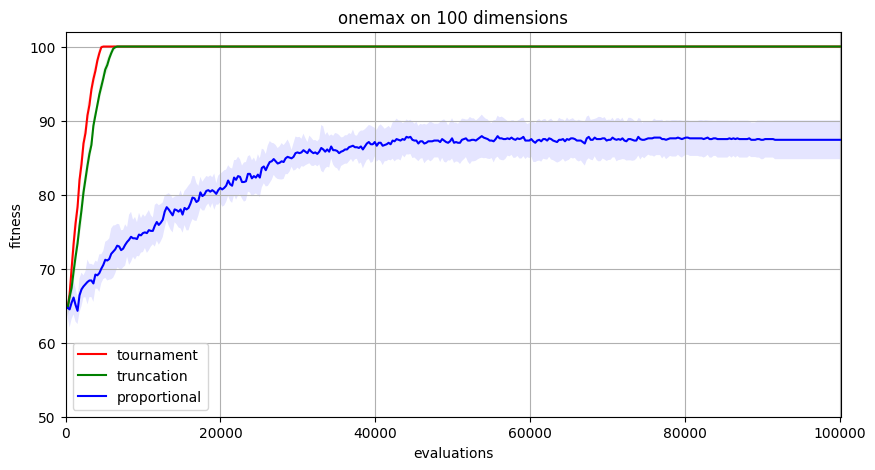

In [6]:
experiment_on("onemax", population_size=128)

### leading one on 20 dimensions


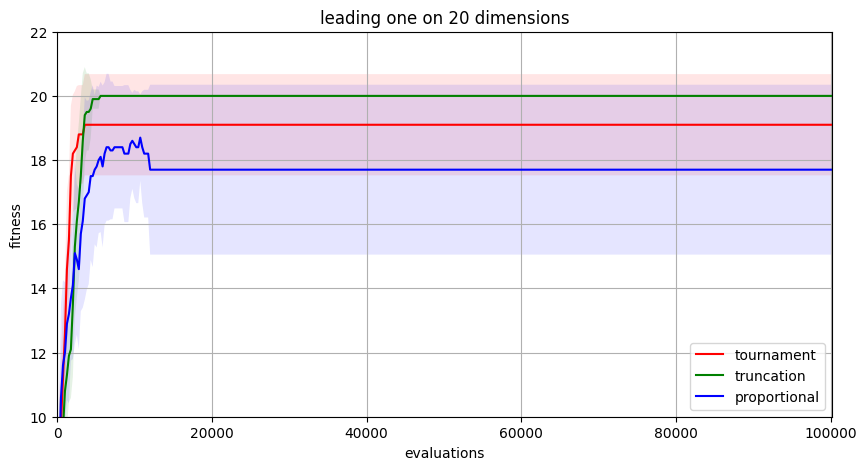

In [7]:
experiment_on("leading_one", population_size=128)

### concatenated trap 5 on 25 dimensions


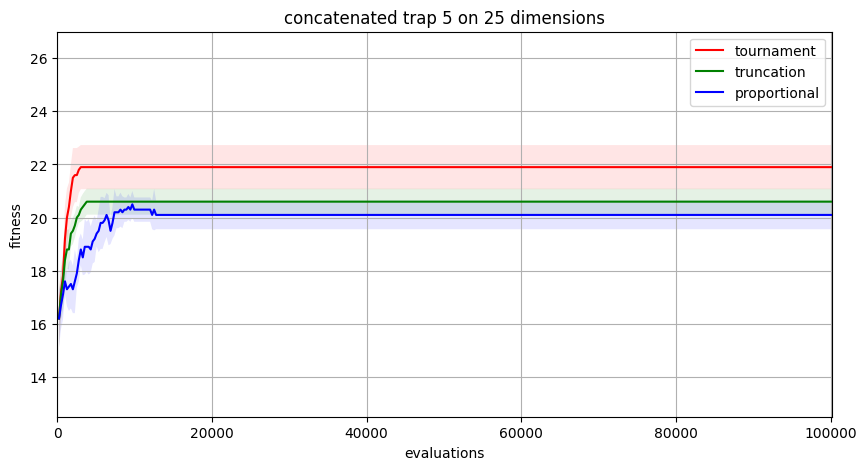

In [8]:
experiment_on("concatenated_trap_5", population_size=128)